In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fdeb6f6d31ad13f6dc3d9555991c04ff11b16d52130b14d84b8e4ec6d3d8326c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# 3B: Style Transfer

### Cristian Barraza, Carla Velásquez

### Ayudante: Giovanni Castiglioni
### Profesor: Pablo Estévez

# Metodología

1.   Función de pérdida
2.   Pre-procesamiento de imágenes
3.   Entrenamiento decoder bloque 5





In [ ]:
#IMPORTS
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from functools import reduce
import time
import pandas as pd
import io

# Función de pérdida

$$
L=||I_o-I_i||_2^2+\lambda ||\Phi (I_o)-\Phi(I_i)||_2^2
$$

Se implementa como clase y como función.

In [ ]:
class Custom_Loss(nn.Module):
    def __init__(self, l):
        super().__init__()
        self.loss=nn.MSELoss()
        self.L=l

    def forward(self, im_in, im_out, fm_in, fm_out):
        return self.loss(im_in,im_out)+self.L*self.loss(fm_in,fm_out)

def CustomLoss(L,im_in,im_out,fm_in,fm_out):
        loss=nn.MSELoss(reduction='sum')
        return loss(im_in,im_out) + L*loss(fm_in,fm_out)

# Pre-procesamiento de imágenes

Se usa COCO dataset 2017 (conjunto de testeo) porque es un intermedio en los tamaños de los archivos

In [ ]:
if not Path('test2017.zip').is_file():
  !wget http://images.cocodataset.org/zips/test2017.zip
  !unzip 'test2017.zip'

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 extracting: test2017/000000251604.jpg  
 extracting: test2017/000000145034.jpg  
 extracting: test2017/000000234833.jpg  
 extracting: test2017/000000025927.jpg  
 extracting: test2017/000000393116.jpg  
 extracting: test2017/000000536478.jpg  
 extracting: test2017/000000365460.jpg  
 extracting: test2017/000000089887.jpg  
 extracting: test2017/000000274928.jpg  
 extracting: test2017/000000310028.jpg  
 extracting: test2017/000000229793.jpg  
 extracting: test2017/000000394339.jpg  
 extracting: test2017/000000564538.jpg  
 extracting: test2017/000000440585.jpg  
 extracting: test2017/000000541512.jpg  
 extracting: test2017/000000395525.jpg  
 extracting: test2017/000000235435.jpg  
 extracting: test2017/000000069964.jpg  
 extracting: test2017/000000131962.jpg  
 extracting: test2017/000000281392.jpg  
 extracting: test2017/000000534893.jpg  
 extracting: test2017/000000128676.jpg  
 extracting: test2017/000000187

Número de imágenes en la carpeta: 40670


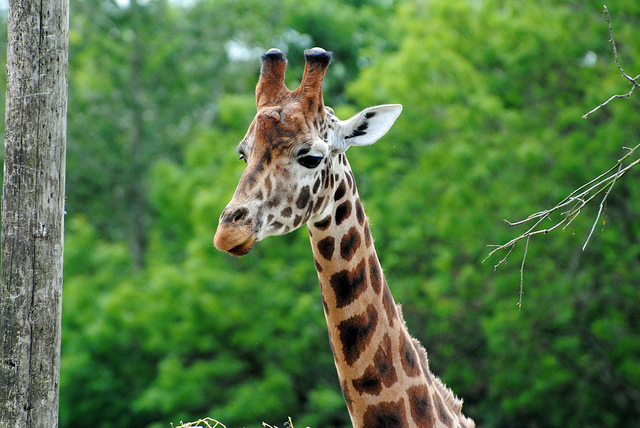

In [ ]:
import IPython
from IPython.display import Image

folder_dir = Path('test2017')

# Conteo de imágenes
img_count = len(list(folder_dir.glob('**/*.jpg')))
print('Número de imágenes en la carpeta:',img_count)

# Prueba de una imagen
Image('test2017/000000000229.jpg')

## Dataset

In [ ]:
from torch.utils.data import Dataset

class COCO(Dataset):

    def __init__(self, folder_path, transform=None):
        super().__init__()
        self.folder_path = folder_path
        self.transform = transform

    def __len__(self):
        len_dataset = len(list(self.folder_path.glob('**/*.jpg')))
        return len_dataset

    def __getitem__(self, idx):
        image=list(self.folder_path.glob('**/*.jpg'))[idx]
        with open(image, 'rb') as file:
          img = Image.open(file)
          if self.transform is not None:
            img = self.transform(img)
        return img

# import glob
# from PIL import Image

# images = glob.glob("Images/*.jpg")
# for image in images:
#   with open(image, 'rb') as file:
#         img = Image.open(file)
#         img.show()

En detalle:

- Se construye la clase heredando la clase Dataset de PyTorch, esto para que la clase NombreDeLaClase sea reconocida también como un Dataset (al igual que cuando se usan los datasets predefinidos como MNIST, CIFAR10, etc.)

- En el constructor, params_adicionales es cualquier parámetro que ustedes necesiten pasarle al dataset que construirán (por ejemplo, la carpeta o URL donde estarán ubicadas las imágenes). Los parámetros de transform y target_transform serán las transformaciones que se le harán a los datos cuando estos sean solicitados. Si bien pueden usar cualquier nombre para estos parámetros, transform y target_transform son los que se usan por lo general, por lo que es bueno mantenerlo así.

- En el constructor, self.images_path y self.labels_path van a contener la información necesaria para acceder a los datos (por ejemplo, images_path puede ser una lista de la forma [data/img1.jpg, data/img2.jpg, ...]). Es importante notar que aquí NO se almacenan las imágenes ya que si se intentara cargar un dataset completo en el constructor, habría un gasto enorme de memoria al instanciar la clase. También se podría tener una sola variable que almacene toda la información (por ejemplo, self.data) y en general, pueden hacerlo como ustedes prefieran (no hay una regla fija para esta parte).

- El método __len__ busca únicamente poder obtener el tamaño del dataset. Por ejemplo, si ustedes definieron el atributo self.images_path como una lista con los nombres de los archivos, bastaría retornar len(self.images_path).

- El método __getitem__ es el método que se llama cuando la red (o más especificamente, el dataloader) solicita una imagen (notar que la forma en la que se invoca este método my_dataset[index] con index un número determinado, por lo que la aleatoriedad al entrenar no ocurre aquí, sino en el dataloader). En este método, se debe cargar la imagen (usando la información contenida en self.images_path y labels_path o en el atributo que ustedes hayan definido en el constructor para guardar la info). Se esperará que este método retorne una tupla (imagen, label). Además, antes de retornar la tupla, se deben aplicar las transformaciones correspondientes (si es que se definió alguna transformación en el constructor del dataset).

En resumen, una clase Dataset solo se usará para cargar las imágenes (a medida que se vayan solicitando) y aplicar las transformaciones que se hayan indicado. Las transformaciones que por lo general se incluyen son ToTensor, Resize, Normalize, etc. y también acá se agregan las transformaciones para data augmentation. Es importante tener en cuenta que, por lo general, las transformaciones para data augmentation son aleatorias (por ejemplo, si se incluye una transf. para rotar, el ángulo de rotación será aleatorio) por lo que my_dataset[10] (la imagen número 11 del dataset) puede retornar una misma imagen con distintas transformaciones cada vez que se llame (por ejemplo, si se le incluyó rotación, puede que la primera vez entregue la imagen rotada 20º, la segunda vez la entregue rotada 40º, etc.). Por lo tanto, es en el dataset donde se hace data augmentation y no en otra parte (si bien podría hacerse en la misma red antes de hacer el forward, no es lo esperado).

Por último, estaría quedando el dataloader. La idea de este es formar los batches (de manera aleatoria si es que así se le indica) a partir de un dataset ya creado para luego pasárselos a la red. Por lo tanto, la estructura natural de un dataloader es la siguiente:


from torch.utils.data import DataLoader
my_dataloader = DataLoader(my_dataset, batch_size=64, shuffle=True)



De este modo, en cada iteración sobre el dataloader, se entregará una tupla (batch, labels) generada (aleatoriamente) a partir de my_dataset para luego hacer my_net(batch) en el entrenamiento/testeo.

Espero que esto les pueda servir a encontrar un poco más natural el funcionamiento de PyTorch 🙂

Saludos!

In [ ]:
st_transform = transforms.Compose([
                                  # transforms.ToPILImage(mode='RGB'),
                                  transforms.Resize(512),
                                  transforms.CenterCrop(512),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.48235, 0.45882, 0.40784),(0.00392156862745098, 0.00392156862745098, 0.00392156862745098))
                                    ])


In [ ]:
style_transfer_dataset=COCO(folder_dir, st_transform)

# Se hacen los datasets de entrenamiento y testeo
train_size = int(0.9 * len(style_transfer_dataset))
test_size = len(style_transfer_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(style_transfer_dataset, [train_size, test_size])

# Del set de entrenamiento se divide una porción para el set de validación
val_size = int(0.2 * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Se verifican las dimensiones de cada dataset
print(len(train_dataset), '\n', len(test_dataset), '\n', len(val_dataset))
total=len(train_dataset)+len(test_dataset)+len(val_dataset)
print(total==len(style_transfer_dataset))

29283 
 4067 
 7320
True


In [ ]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2, pin_memory=True)

# train_features = next(iter(train_loader))
# print(f"Feature batch shape: {train_features.size()}")
# for i in range(10):
#   img = train_features[i].squeeze()
#   print(img.size())
#   plt.imshow(img[0], cmap="rgb")
#   plt.show()


# Auto encoder

## Encoder (VGG16)

Se usa esta CNN, pero sin sus capas fully connected.

In [ ]:
vgg16=models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES)
vgg16=vgg16.features[0:31] # Se quedan sólo las capas convolucionales
vgg16.eval()
# Guardar en GPU
vgg16_path='vgg16.pth'
torch.save(vgg16.state_dict(), vgg16_path)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Subir con la GPU (ejemplo para entrenar decoder)
device = torch.device("cuda")
vgg16.load_state_dict(torch.load(vgg16_path))
vgg16.to(device);

## Decoder (simétrico a VGG16)

Se saca del GitHub y se modifica para que sea VGG16 en vez de VGG19

In [ ]:
feature_invertor_conv5_1 = nn.Sequential(
    # Bloque 5 inverso
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    
    # Bloque 4 inverso
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,512,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512,256,(3, 3)),
    nn.ReLU(),

    # Bloque 3 inverso
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,256,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256,128,(3, 3)),
    nn.ReLU(),

    # Bloque 2 inverso
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,128,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128,64,(3, 3)),
    nn.ReLU(),

    # Bloque 1 inverso
    nn.UpsamplingNearest2d(scale_factor=2),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,64,(3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64,3,(3, 3)),
)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            # Bloque 5 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            
            # Bloque 4 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,512,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512,256,(3, 3)),
            nn.ReLU(),

            # Bloque 3 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,256,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256,128,(3, 3)),
            nn.ReLU(),

            # Bloque 2 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,128,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128,64,(3, 3)),
            nn.ReLU(),

            # Bloque 1 inverso
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,64,(3, 3)),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64,3,(3, 3)),
        )

        if Path('decoder.pth').is_file():
          self.model.load_state_dict(torch.load("decoder.pth"))

    def forward(self, x):
        out = self.model(x)
        return out

## Función de entrenamiento y visualización

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [ ]:
def train_step(x_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, x_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=True,
    data_augmentation=False,
):
    original_transform = transforms.Compose([
        transforms.ToTensor(),
        # Se cambian por los vectores usados para el 
        transforms.Normalize((0.48235, 0.45882, 0.40784), (0.00392156862745098, 0.00392156862745098, 0.00392156862745098)),
    ])

    if data_augmentation:
      
      train_dataset.dataset.transform = transforms.Compose([
          original_transform,
          transforms.RandomHorizontalFlip(),
          transforms.Lambda(lambda x: x + torch.randn(3, 1, 1) * 0.05)
        ])

    else:
        train_dataset.dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.dataset.transform}")
    print(f"Using validation transform: {val_dataset.dataset.transform}")

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, x_batch in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                # y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            # train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            # cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                # train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        # train_acc = cumulative_train_corrects / train_acc_count

        # curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    if data_augmentation:
        train_dataset.dataset.transform = original_transform

    return curves

## Bloque de entrenamiento del decoder

In [ ]:
lr = 5e-4
dropout_p = 0.5
batch_size = 10
criterion = Custom_Loss(l=1)

epochs = 1
model = Decoder()

curves = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
)

# Guardar en GPU
decoder_path='decoder.pth'
torch.save(Decoder.state_dict(), decoder_path)

#show_curves(curves)

Using train transform: Compose(
    ToTensor()
    Normalize(mean=(0.48235, 0.45882, 0.40784), std=(0.00392156862745098, 0.00392156862745098, 0.00392156862745098))
)
Using validation transform: Compose(
    ToTensor()
    Normalize(mean=(0.48235, 0.45882, 0.40784), std=(0.00392156862745098, 0.00392156862745098, 0.00392156862745098))
)
Epoch 1/1


AttributeError: ignored

# Referencias


Ref 1: Li, Y., Fang, C., Yang, J., Wang, Z., Lu, X., & Yang, M. H. (2017). Universal style transfer via feature transforms. In Advances in neural information processing systems (pp. 386-396). https://arxiv.org/abs/1705.08086
Ref 2: Gatys, L. A., Ecker, A. S., & Bethge, M. (2015). A neural algorithm of artistic style. https://arxiv.org/abs/1508.06576
Ref 3: PyTorch implementation of "Universal Style Transfer via Feature Transforms":
https://github.com/pietrocarbo/deep-transfer
Ref 4: Simonyan, K., Zisserman, A. (2014). Very Deep Convolutional Networks for Large Scale Image Recognition. https://arxiv.org/abs/1409.1556
Ref 5: Transferencia de aprendizaje y ajuste
https://www.tensorflow.org/tutorials/images/transfer_learning
Ref 6: COCO: Common Objects in Context
https://cocodataset.org/
